### Applied CAPM

Let's study an example of calculating a CAPM $\beta$ using real market data.  Begin by loading the `pandas_datareader` module for importing data.  We'll also import the `datetime` module so that we can select stock prices over a given date range.

In [1]:
import pandas_datareader.data as web
from datetime import datetime

We'll use AlphaVantage for stock prices.  Load up the API key that we stored earlier.

In [3]:
import pickle
with open('../pickle_jar/av_key.p', 'rb') as f:
    api_key = pickle.load(f)
print(api_key[0:3])

VAS


The stock we'll use for our study is AAPL.  Let's collect return data over 2015-2019.

In [4]:
start = datetime(2015, 1, 1)
end = datetime(2019, 12, 31)

aapl = web.DataReader('AAPL', 'av-daily-adjusted', start, end, api_key=api_key)

Print the head to see a snapshot of the data.

In [6]:
aapl.head()

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
2015-01-02,111.39,111.44,107.350,109.33,24.779987,53204626,0.0,1.0
2015-01-05,108.29,108.65,105.410,106.25,24.081896,64285491,0.0,1.0
2015-01-06,106.54,107.43,104.630,106.26,24.084162,65797116,0.0,1.0
2015-01-07,107.20,108.20,106.695,107.75,24.421875,40105934,0.0,1.0
2015-01-08,109.23,112.15,108.700,111.89,25.360219,59364547,0.0,1.0


Create a column of stock returns using the adjusted close data.

<AxesSubplot:>

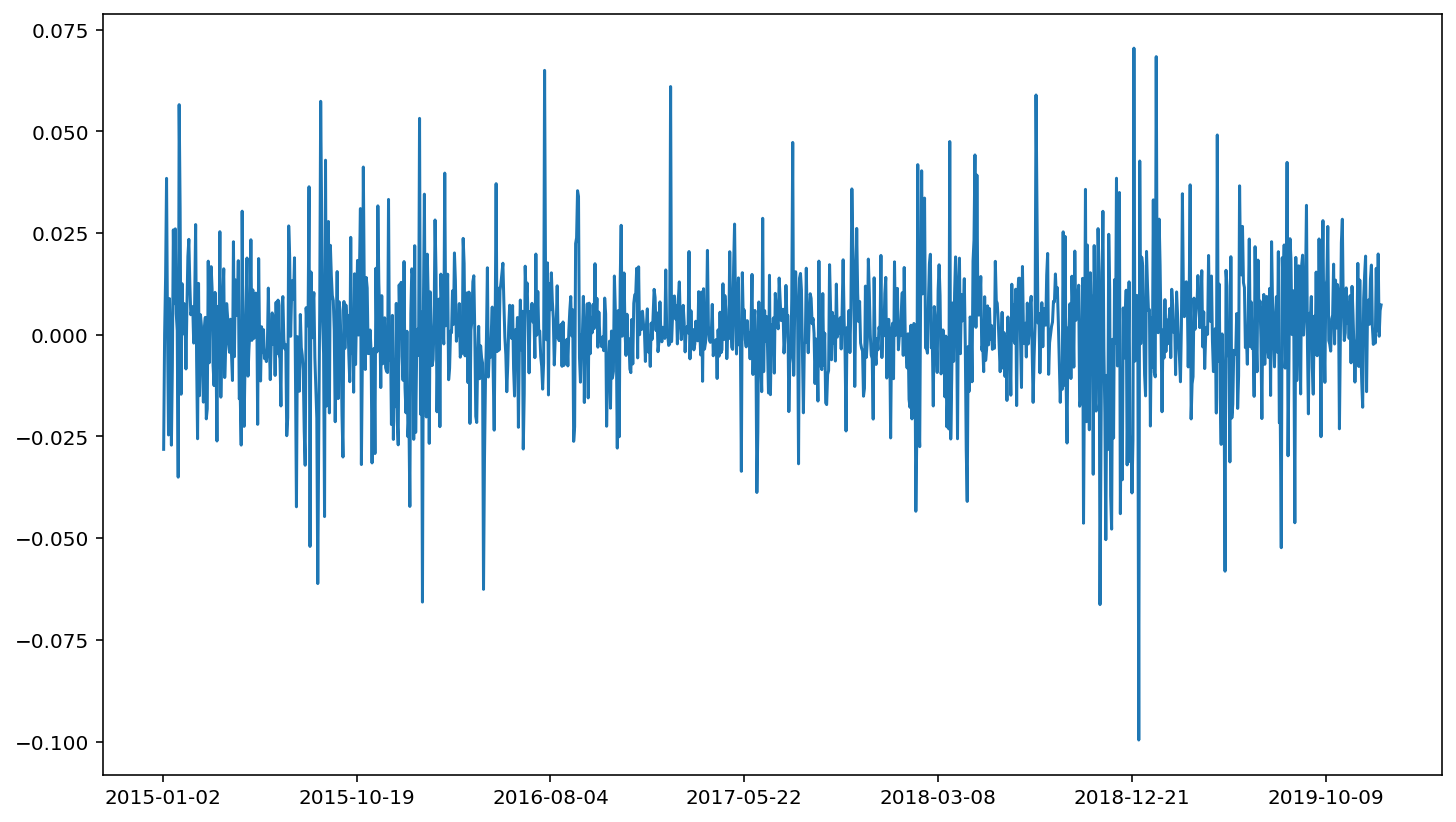

In [7]:
aapl['ret'] = aapl['adjusted close'].pct_change()
aapl['ret'].plot()

Now we need some market return data.  The Fama-French data library has that available.

Note that Fama-French API calls via `pandas_datareader` return a dictionary of values, rather than a DataFrame.

In [8]:
ff = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start, end)
ff.keys()

dict_keys([0, 'DESCR'])

The `'DESCR'` gives some details about the data while the `0` key stores the actual DataFrame.

In [9]:
print(ff['DESCR'])

F-F Research Data Factors daily
-------------------------------

This file was created by CMPT_ME_BEME_RETS_DAILY using the 202107 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2021 Kenneth R. French

  0 : (1258 rows x 4 cols)


In [10]:
ffdf = ff[0]
ffdf.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2015-01-02,-0.12,-0.62,0.08,0.0
2015-01-05,-1.84,0.33,-0.68,0.0
2015-01-06,-1.04,-0.78,-0.31,0.0
2015-01-07,1.19,0.20,-0.65,0.0
2015-01-08,1.81,-0.11,-0.28,0.0


One tricky issue is that, while the head printouts for the two DataFrames make the index items appear similar, they are not.  Data from Fama-French returns an datetime variable as an index (which is more useful) whereas data from the AlphaVantage API call returns the index as a string.

In [11]:
print(aapl.index.dtype)
print(ffdf.index.dtype)

object
datetime64[ns]


We'll want the index of the AlphaVantage data to be a datetime (to match the Fama-French data).  To do this, we simply us the `.to_datetime()` function on the `.index` variable of the AlphaVantage DataFrame.

In [12]:
import pandas as pd
aapl.index = pd.to_datetime(aapl.index, format='%Y-%m-%d')
print(aapl.index.dtype)

datetime64[ns]


With both DataFrames using the same index, we can merge the two using the index value as the merge key.  Thus, rather than using `left_on` and `right_on` to specify the merge variable, we specify `left_index=True` and `right_index=True` to tell Python that the merging variable will be the index.

In [13]:
df = aapl.merge(ffdf, left_index=True, right_index=True)
df.head()

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,ret,Mkt-RF,SMB,HML,RF
2015-01-02,111.39,111.44,107.350,109.33,24.779987,53204626,0.0,1.0,NaN,-0.12,-0.62,0.08,0.0
2015-01-05,108.29,108.65,105.410,106.25,24.081896,64285491,0.0,1.0,-0.028172,-1.84,0.33,-0.68,0.0
2015-01-06,106.54,107.43,104.630,106.26,24.084162,65797116,0.0,1.0,0.000094,-1.04,-0.78,-0.31,0.0
2015-01-07,107.20,108.20,106.695,107.75,24.421875,40105934,0.0,1.0,0.014022,1.19,0.20,-0.65,0.0
2015-01-08,109.23,112.15,108.700,111.89,25.360219,59364547,0.0,1.0,0.038422,1.81,-0.11,-0.28,0.0


Remember that the $y$ variable in a CAPM equation is the *excess* return of the stock.  So, subtract the company's return from the risk free rate.

In [14]:
df['eret'] = df['ret']*100 - df['RF']

We can now estimate a CAPM $\beta$.

In [15]:
import statsmodels.formula.api as smf

mod = smf.ols('eret ~ Q("Mkt-RF")', data=df).fit()
print(mod.summary())
print(mod.params)

                            OLS Regression Results                            
Dep. Variable:                   eret   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     995.8
Date:                Sun, 26 Sep 2021   Prob (F-statistic):          2.17e-161
Time:                        22:26:10   Log-Likelihood:                -1978.4
No. Observations:                1257   AIC:                             3961.
Df Residuals:                    1255   BIC:                             3971.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0417      0.033      1.264      

Putting this all together, we get the code below.

In [17]:
def get_beta(start, end, ticker):
    with open('../../pickle_jar/av_key.p', 'rb') as fout:
        api_key = pickle.load(fout)
    stock = web.DataReader(ticker, 'av-daily-adjusted', start, end, api_key=api_key)
    stock['ret'] = stock['adjusted close'].pct_change()*100
    ff = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start, end)[0]
    stock.index = pd.to_datetime(stock.index, format='%Y-%m-%d')
    df = stock.merge(ff, left_index=True, right_index=True)
    df['eret'] = df['ret'] - df['RF']
    mod = smf.ols('eret ~ Q("Mkt-RF")', data=df)
    res = mod.fit()
    print(res.summary())
    alpha, beta = res.params
    return beta

get_beta(start = datetime(2018,1,1), end = datetime(2019,12,31), ticker='GOOG')

                            OLS Regression Results                            
Dep. Variable:                   eret   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     711.9
Date:                Sun, 26 Sep 2021   Prob (F-statistic):           3.49e-98
Time:                        22:31:28   Log-Likelihood:                -741.01
No. Observations:                 502   AIC:                             1486.
Df Residuals:                     500   BIC:                             1494.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0016      0.047      0.035      

1.3092647331440843